In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model

In [2]:
class deepRBF(Kern):
    
    def __init__(self,input_dim,variance1=1.,lengthscale=1.,variance2=1.,active_dims=None):
        super(deepRBF, self).__init__(input_dim, active_dims, 'deep_rbf')
        #assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance1 = Param('variance1', variance1)
        self.lengthscale = Param('lengtscale', lengthscale)
        self.variance2 = Param('variance2', variance2)
        #self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.link_parameters(self.variance1, self.lengthscale, self.variance2)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        return self.variance2*np.power(1 + tmp2,-0.5)
    
    def Kdiag(self,X):
        return self.variance2*np.ones(X.shape[0])
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1

        dvar2 = np.power(1 + tmp2, -0.5)
        #dl1 = self.power * self.variance * dist2 * self.lengthscale**(-3) * (1 + dist2/2./self.power)**(-self.power-1)
        dvar1 = (-1.)*self.variance2*tmp1*np.power(1+tmp2,-1.5)
        dl = self.variance1*self.variance2*np.exp((-1.)*dist2)*dist2/self.lengthscale*np.power(1+tmp2,-1.5)
        #dp = - self.variance * np.log(1 + dist2/2.) * (1 + dist2/2.)**(-self.power)

        self.variance1.gradient = np.sum(dvar1*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        self.variance2.gradient = np.sum(dvar2*dL_dK)
        #self.lenthscale2.gradient = np.sum(dl2*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance2.gradient = np.sum(dL_dKdiag)
        # here self.lengthscale and self.power have no influence on Kdiag so target[1:] are unchanged
        
    def gradients_X(self,dL_dK,X,X2):
        """derivative of the covariance matrix with respect to X."""
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        tmp3 = np.power(1+tmp2,-1.5)

        #dX = -self.variance*self.power * (X-X2.T)/self.lengthscale**2 *  (1 + dist2/2./self.lengthscale)**(-self.power-1)
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2.T)/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 *((X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2) / self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #return np.sum(dL_dK*dX,1)[:,None]
        #return np.sum(dX*dL_dK,1)[:,None]
        dX_tmp = (-1.)*self.variance1*self.variance2/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        return ((dL_dK*dX_tmp)[:,:,None]*(X[:,None,:] - X2[None,:,:])).sum(1)
    
    def gradients_X_diag(self,dL_dKdiag,X):
        # no diagonal gradients
        pass
    


In [8]:
import pods

default_seed = 10000

data = pods.datasets.toy_linear_1d_classification(seed=default_seed)
Y = data['Y'][:, 0:1]
Y[Y.flatten() == -1] = 0

# Model definition
m1 = GPy.models.GPClassification(data['X'], Y)

In [9]:
m1.optimize(messages=1)

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a20af4940>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a20ad46a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a20af4fd0>]}

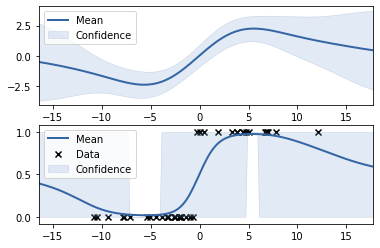

In [10]:
fig, axes = plt.subplots(2, 1)
m1.plot_f(ax=axes[0])
m1.plot(ax=axes[1])

In [12]:
deep_rbf = deepRBF(input_dim=1)

m2 = GPy.models.GPClassification(data['X'], Y, deep_rbf)

In [14]:
m2.optimize(messages=1)

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a20d87c50>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a20d77828>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a20d876a0>]}

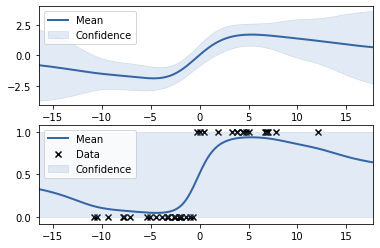

In [15]:
fig2, axes2 = plt.subplots(2, 1)
m2.plot_f(ax=axes2[0])
m2.plot(ax=axes2[1])

## Oil data

In [17]:
data1 = pods.datasets.oil()
Xtrain = data1['X']
Xtest = data1['Xtest']
Ytrain = data1['Y'][:, 0:1]
Ytest = data1['Ytest'][:, 0:1]
Ytrain[Ytrain.flatten()==-1] = 0
Ytest[Ytest.flatten()==-1] = 0

In [20]:
num_inducing=50 
max_iters=100

m_oil = GPy.models.SparseGPClassification(Xtrain, Ytrain, kernel=None, num_inducing=num_inducing)
m_oil.Ytest = Ytest

m_oil['.*len'] = 10.

In [22]:
m_oil.optimize(messages=1)

In [23]:
probs = m_oil.predict(Xtest)[0]
GPy.util.classification.conf_matrix(probs, Ytest)

99.5 % instances correctly classified
          |  1         |  0         | 
----------|------------|------------|
1         |  323.0     |  1         | 
0         |  4         |  672.0     | 


(0.005, 323.0, 4, 672.0, 1)

In [24]:
dRBF = deepRBF(input_dim=Xtrain.shape[1])

m_oil_d = GPy.models.SparseGPClassification(Xtrain, Ytrain, kernel=dRBF, num_inducing=num_inducing)
m_oil_d.Ytest = Ytest

m_oil_d['.*len'] = 10.

In [30]:
m_oil_d.optimize(messages=1)

In [31]:
probs_d = m_oil_d.predict(Xtest)[0]
GPy.util.classification.conf_matrix(probs_d, Ytest)

99.3 % instances correctly classified
          |  1         |  0         | 
----------|------------|------------|
1         |  320.0     |  4         | 
0         |  3         |  673.0     | 


(0.007, 320.0, 3, 673.0, 4)

## Crescent data

In [33]:
data_c = pods.datasets.crescent_data(seed=default_seed)
Y_c = data_c['Y']
Y_c[Y_c.flatten()==-1] = 0

In [34]:
m_c = GPy.models.GPClassification(data_c['X'], Y_c, kernel=None)

In [35]:
m_c['.*len'] = 5.
m_c.optimize(messages=1)

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a2388d0b8>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1a234a7f60>]}

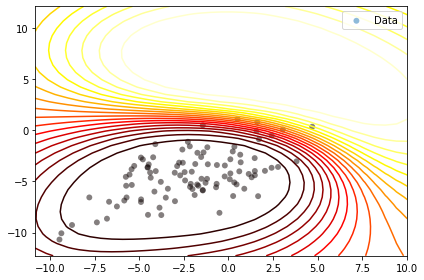

In [36]:
m_c.plot()

In [38]:
#m_c_fitc = GPy.models.FITCClassification(data_c['X'], Y_c, kernel=None, num_inducing=10)
#m_c_fitc['.*len'] = 3.

dd_rbf = deepRBF(input_dim=data_c['X'].shape[1])

m_c_d = GPy.models.GPClassification(data_c['X'], Y_c, kernel=dd_rbf)

In [39]:
m_c_d['.*len'] = 5.
m_c_d.optimize(messages=1)

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a23353b00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1077e6160>]}

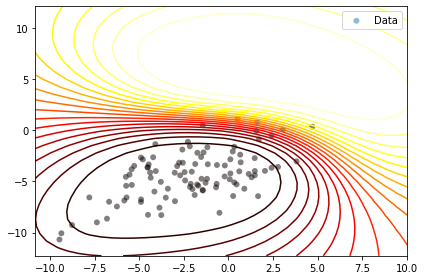

In [40]:
m_c_d.plot()